In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 线性回归方程的偏回归系数是通过OLS最小二乘法得到的，其需要满足一些前期假设
### 自变量与因变量之间存在线性关系；
### 自变量之间不存在多重共线性；
### 回归模型的残差服从正态分布；
### 回归模型的残差满足方差齐性（即方差为某个固定值）；
### 回归模型的残差之间互相独立；

#### 加载数据高炉煤气联合循环发电(CCPP)数据集

In [2]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [3]:
#读取数据
ccpp = pd.read_excel('CCPP.xlsx')
ccpp.describe()
# AT:温度
# V:压力
# AP:相对湿度
# RH:排气量
# PE:发电量

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


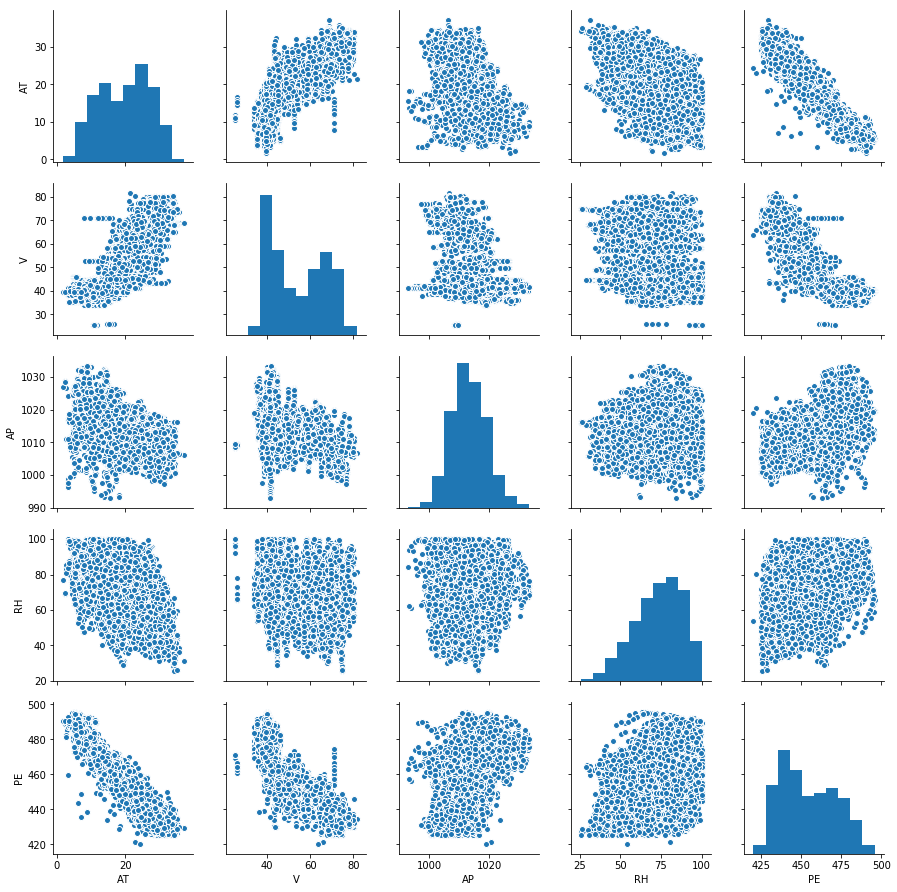

In [4]:
# 绘制各变量之间的散点图
sns.pairplot(ccpp)
plt.show()

In [5]:
### 从上面的散点图可以大概看到，AP相对湿度和RH排气量之间没有明显的线性关系，具体我们还需要使用皮尔逊相关系数做判断
ccpp.corrwith(ccpp.PE)

AT   -0.948128
V    -0.869780
AP    0.518429
RH    0.389794
PE    1.000000
dtype: float64

### 一般情况下，当Pearson相关系数低于0.4，则表明变量之间存在弱相关关系；
### 当Pearson相关系数在0.4~0.6之间，则说明变量之间存在中度相关关系；
### 当相关系数在0.6以上时，则反映变量之间存在强相关关系。
### 经过对比发现，PE与RH之间的为弱相关关系，故不考虑将该变量纳入模型。
### 当然，变量之间不存在线性关系并不代表不存在任何关系，可能是二次函数关系、对数关系等，所以一般还需要进行检验和变量转换。

# 多重共线性检验

### 多重共线性的后果
### 导致OLS估计量可能无效；
### 增大OLS估计量的方差；
### 变量的显著性检验将失去意义；
### 模型缺乏稳定性；

## 可以使用VIF Viarance inflate factor来检验多重共线性，如果VIF大于10，则说明变量存在多重共线性。一旦发现变量之间存在多重共线性的话，可以考虑删除变量和重新选择模型（岭回归法）

In [8]:
# 将因变量PE，自变量AT,V,AP和截距项（值为1的1维数组）以数据框的形式组合起来
y, X = dmatrices('PE~AT+V+AP', data = ccpp, return_type='dataframe')

In [9]:
y.head()

,PE
0,463.26
1,444.37
2,488.56
3,446.48
4,473.90


In [10]:
X.head()

,Intercept,AT,V,AP
0,1.0,14.96,41.76,1024.07
1,1.0,25.18,62.96,1020.04
2,1.0,5.11,39.40,1012.16
3,1.0,20.86,57.32,1010.24
4,1.0,10.82,37.50,1009.23


In [11]:
# 构造空的数据框
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [12]:
vif["features"] = X.columns
vif

,VIF Factor,features
0,39847.945838,Intercept
1,3.888380,AT
2,3.482090,V
3,1.348401,AP


In [13]:
# 结果显示，所有自变量的VIF均低于10，说明自变量之间并不存在多重共线性的隐患。

In [14]:
#异常点检测

In [15]:
fit = sm.formula.ols('PE~AT+V+AP',data=ccpp).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 3.568e+04
Date:                Tue, 28 Nov 2017   Prob (F-statistic):               0.00
Time:                        10:23:34   Log-Likelihood:                -28758.
No. Observations:                9568   AIC:                         5.752e+04
Df Residuals:                    9564   BIC:                         5.755e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    344.0714      9.977     34.487      0.000     324.515     363.628
AT            -1.6348      0.013   -123.613      0.000      -1.661      -1.609
V             -0.3283      0.007    -44.735      0.000      -0.343      -0.314
AP             0.1582      0.010     16.183      0.000       0.139       0.177
==============================================================================
Omnibus:                      542.551   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1896.378
Skew:                          -0.198   Prob(JB):                         0.00
Kurtosis:                       5.145   Cond. No.                     2.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
from sklearn.metrics import mean_squared_error
pred = fit.predict()
np.sqrt(mean_squared_error(ccpp.PE,pred))

4.8877198348601656

 ### 关于异常点的检测方法，一般可以通过高杠杆值点（帽子矩阵）或DFFITS值、学生化残差、cook距离和covratio值来判断。

In [17]:
#离群点检测
outliers = fit.get_influence()
# 高杠杆值点（帽子矩阵）
leverage = outliers.hat_matrix_diag
# dffits值
dffits = outliers.dffits[0]
# 学生化残差
resid_stu = outliers.resid_studentized_external
# cook距离
cook = outliers.cooks_distance[0]
# covratio值
covratio = outliers.cov_ratio
# 将上面的几种异常值检验统计量与原始数据集合并
contat1 = pd.concat([pd.Series(leverage, name = 'leverage'),pd.Series(dffits, name = 'dffits'),
                     pd.Series(resid_stu,name = 'resid_stu'),pd.Series(cook, name = 'cook'),
                     pd.Series(covratio, name = 'covratio'),],axis = 1)
ccpp_outliers = pd.concat([ccpp,contat1], axis = 1)
ccpp_outliers.head()

,AT,V,AP,RH,PE,leverage,dffits,resid_stu,cook,covratio
0,14.96,41.76,1024.07,73.17,463.26,0.000549,-0.022075,-0.941799,1.218279e-04,1.000597
1,25.18,62.96,1020.04,59.08,444.37,0.000487,0.003668,0.166180,3.363110e-06,1.000894
2,5.11,39.40,1012.16,92.14,488.56,0.000787,0.032756,1.167083,2.682360e-04,1.000636
3,20.86,57.32,1010.24,76.64,446.48,0.000137,-0.010641,-0.908639,2.830953e-05,1.000210
4,10.82,37.50,1009.23,96.62,473.90,0.000514,0.001008,0.044471,2.542535e-07,1.000932


### 当高杠杆值点（或帽子矩阵）大于2(p+1)/n时，则认为该样本点可能存在异常（其中p为自变量的个数，n为观测的个数）；
### 当DFFITS统计值大于2sqrt((p+1)/n)时 ，则认为该样本点可能存在异常；当学生化残差的绝对值大于2，则认为该样本点可能存在异常；
### 对于cook距离来说，则没有明确的判断标准，一般来说，值越大则为异常点的可能性就越高；
### 对于covratio值来说，如果一个样本的covratio值离数值1越远，则认为该样本越可能是异常值。
### 这里我们就以学生化残差作为评判标准，因为其包含了帽子矩阵和DFFITS的信息。

In [18]:
# 计算异常值数量的比例
outliers_ratio = sum(np.where((np.abs(ccpp_outliers.resid_stu)>2),1,0))/ccpp_outliers.shape[0]
outliers_ratio

0.037102842809364552

## 对于异常值的处理，我们可以考虑下面几种办法：
### 当异常比例极低时（如5%以内），可以考虑直接删除；
### 当异常比例比较高时，可以考虑将异常值衍生为哑变量，即异常值对应到1，非异常值则对应到0；
### 将单独把异常值提取出来，另行建模；
### 这里为了简单起见，我们将3.7%的异常值作删除处理。

In [19]:
# 删除异常值
ccpp_outliers = ccpp_outliers.loc[np.abs(ccpp_outliers.resid_stu)<=2,]
ccpp_outliers.head()

,AT,V,AP,RH,PE,leverage,dffits,resid_stu,cook,covratio
0,14.96,41.76,1024.07,73.17,463.26,0.000549,-0.022075,-0.941799,1.218279e-04,1.000597
1,25.18,62.96,1020.04,59.08,444.37,0.000487,0.003668,0.166180,3.363110e-06,1.000894
2,5.11,39.40,1012.16,92.14,488.56,0.000787,0.032756,1.167083,2.682360e-04,1.000636
3,20.86,57.32,1010.24,76.64,446.48,0.000137,-0.010641,-0.908639,2.830953e-05,1.000210
4,10.82,37.50,1009.23,96.62,473.90,0.000514,0.001008,0.044471,2.542535e-07,1.000932


In [20]:
# 重新建模
fit2 = sm.formula.ols('PE~AT+V+AP',data = ccpp_outliers).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 4.550e+04
Date:                Tue, 28 Nov 2017   Prob (F-statistic):               0.00
Time:                        10:23:59   Log-Likelihood:                -26434.
No. Observations:                9213   AIC:                         5.288e+04
Df Residuals:                    9209   BIC:                         5.291e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    349.8258      8.857     39.498      0.000     332.465     367.187
AT            -1.6719      0.012   -141.063      0.000      -1.695      -1.649
V             -0.3285      0.006    -50.545      0.000      -0.341      -0.316
AP             0.1531      0.009     17.647      0.000       0.136       0.170
==============================================================================
Omnibus:                      455.104   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.929
Skew:                           0.058   Prob(JB):                     6.97e-41
Kurtosis:                       2.316   Cond. No.                     2.02e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
# 计算模型的RMSE值
pred2 = fit2.predict()
np.sqrt(mean_squared_error(ccpp_outliers.PE, pred2))

4.2644419500649375

### 通过对比fit和fit2，将异常值删除后重新建模的话，效果会更理想一点，具体表现为：
### 信息准则（AIC和BIC）均变小，同时RMSE（误差均方根）也由原来的4.89降低到4.26。

# 正态性检测

### 当模型的残差服从正态性假设时，才能保证模型偏回归系数对于的t值和模型的F值是有效的。
### 故模型建好后，要对模型的残差进行正态性检验。
### 关于正态性检验由两类方法，即定性的图形法（直方图、PP图和QQ图）和定量的非参数法（Shapiro检验和K-S检验）。

In [22]:
# 残差的正态性检验（直方图法）
resid = fit2.resid
# 中文和负号的正常显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

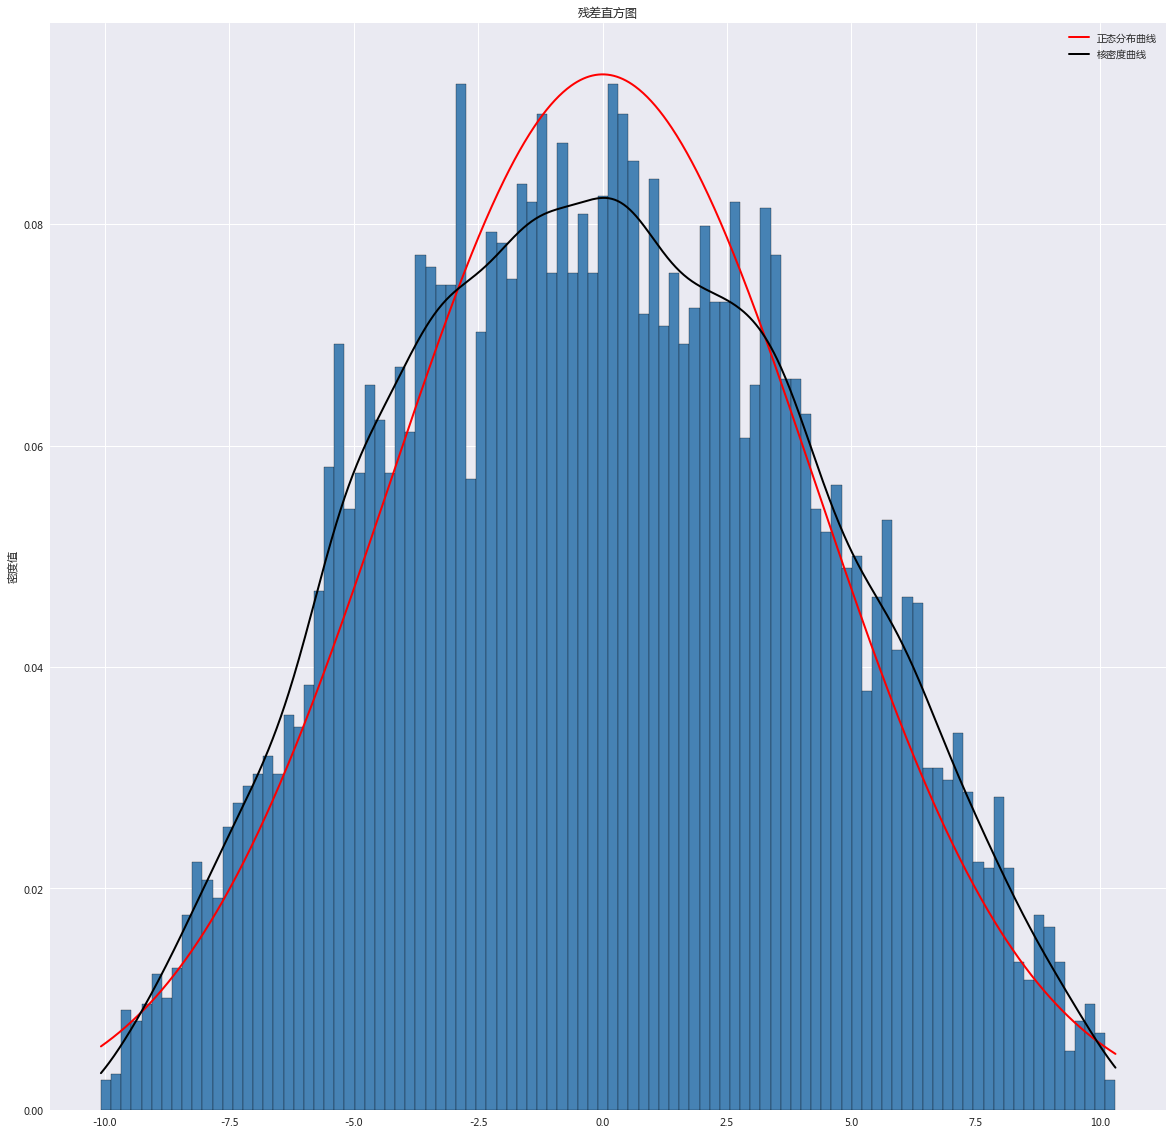

In [23]:
plt.figure(figsize=(20,20))
plt.hist(resid, # 绘图数据
        bins = 100, # 指定直方图条的个数
        normed = True, # 设置为频率直方图
        color = 'steelblue', # 指定填充色
        edgecolor = 'k') # 指定直方图的边界色

# 设置坐标轴标签和标题
plt.title('残差直方图')
plt.ylabel('密度值')

# 生成正态曲线的数据
x1 = np.linspace(resid.min(), resid.max(), 1000)
normal = mlab.normpdf(x1, resid.mean(), resid.std())
# 绘制正态分布曲线
plt.plot(x1,normal,'r-', linewidth = 2, label = '正态分布曲线') 

# 生成核密度曲线的数据,KDE[kernal dense curve]核密度曲线
kde = mlab.GaussianKDE(resid)
x2 = np.linspace(resid.min(), resid.max(), 1000)
# 绘制核密度曲线
plt.plot(x2,kde(x2),'k-', linewidth = 2, label = '核密度曲线')

# 去除图形顶部边界和右边界的刻度
plt.tick_params(top='off', right='off')
# 显示图例
plt.legend(loc='best')

plt.show()

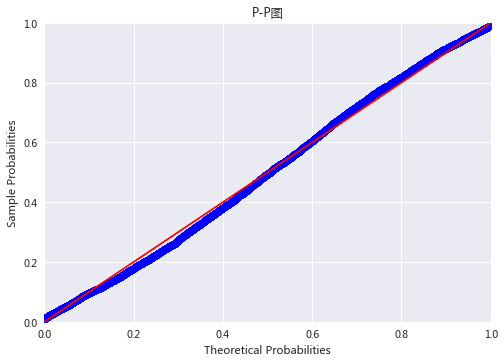

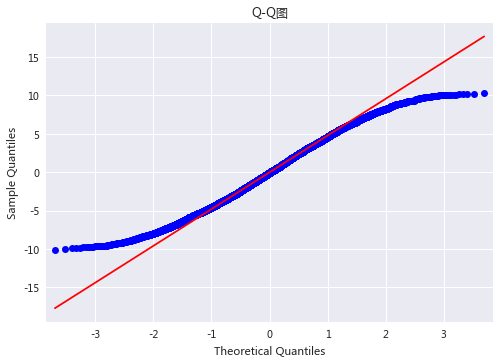

In [24]:
# 残差的正态性检验（PP图和QQ图法）
pp_qq_plot = sm.ProbPlot(resid)
sm.figsize = (20,10)

pp_qq_plot.ppplot(line = '45')
plt.title('P-P图')

pp_qq_plot.qqplot(line = 'q')
plt.title('Q-Q图')# 显示图形plt.show()
plt.show()

In [27]:
# 残差的正态性检验（非参数法）
standard_resid = (resid-np.mean(resid))/np.std(resid)
stats.kstest(standard_resid, 'norm')

KstestResult(statistic=0.030784687051174486, pvalue=5.2151288608458548e-08)

#### 由于shapiro正态性检验对样本量的要求是5000以内；而本次数据集的样本量由9000多，故选择K-S来完成正态性检验。
#### 从K-S检验的P值来看，拒绝了残差服从正态分布的假设，即认为残差并不满足正态性假设这个前提。
#### 如果残差不服从正态分布的话，建议对Y变量进行box-cox变换处理。由于fit2模型的残差并没有特别明显的偏态（偏度为0.058，接近于0），
#### 故这里就不对Y变量进行box-cox变换了。如果需要变换的话，可以以下面的代码为例：

In [ ]:
import scipy.stats as stats# 找到box-cox变换的lambda系数
lamd = stats.boxcox_normmax(ccpp.AP, method = 'mle')
# 对Y进行变换
your_data_frame['trans_y'] = stats.boxcox(ccpp.AP, lamd)
# 建模
fit = sm.formula.ols('y~x1+x2+...', data = your_data_frame).fit()
fit.summary()